<a href="https://colab.research.google.com/github/divya-r-kamat/NLP-With-PyTorch/blob/master/BERT/FakeNewsClassification/Fake_News_Classification_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spam Classification using BERT

Google Colab offers free GPUs and TPUs! Since we'll be training a large neural network it's best to take advantage of this (in this case we'll attach a GPU), otherwise training will take a very long time.

A GPU can be added by going to the menu and selecting:

Edit 🡒 Notebook Settings 🡒 Hardware accelerator 🡒 (GPU)

Then run the following cell to confirm that the GPU is detected.

In [1]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In order for torch to use the GPU, we need to identify and specify the GPU as the device. Later, in our training loop, we will load data onto the device.

In [2]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


## Installing the Hugging Face Library

Next, let's install the transformers package from Hugging Face which will give us a pytorch interface for working with BERT. (This library contains interfaces for other pretrained language models like OpenAI's GPT and GPT-2.) 
The library also includes task-specific classes for token classification, question answering, next sentence prediciton, etc. Using these pre-built classes simplifies the process of modifying BERT for your purposes.

In [3]:
!pip install transformers

     |████████████████████████████████| 2.2MB 18.4MB/s 
     |████████████████████████████████| 3.3MB 56.6MB/s 
     |████████████████████████████████| 870kB 56.5MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl size=886084 sha256=ef327e7c0927b5c41d9d111928d1e7e2e881bded1998e85428e12db64456c1c8
  Stored in directory: /root/.cache/pip/wheels/3e/fb/c0/13ab4d63d537658f448366744654323077c4d90069b6512f3c
Successfully built sacremoses


## Import Libraries

In [4]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from torchtext.legacy.data import Field, TabularDataset, BucketIterator, Iterator
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch.nn as nn
import time
import math

## Load Dataset

In [5]:
df = pd.read_csv("/content/drive/MyDrive/BERT/FakeNews_Classification/news.csv")

# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(df.shape[0]))

# Display 10 random rows from the data.
df.sample(10)

Number of training sentences: 6,335



,Unnamed: 0,title,text,label
2971,4473,Republicans Target Senate Democrats Over Menen...,Republicans are making clear they will do what...,REAL
6110,7188,BREAKING : Sources Inside the FBI Say Hillary ...,BREAKING : Sources Inside the FBI Say Hillary ...,FAKE
3036,4900,Why did Mexico invite Donald Trump for a visit...,President Enrique Peña Nieto has invited both ...,REAL
2431,637,Elizabeth Warren declares herself ready to be ...,Senator Elizabeth Warren has declared herself ...,REAL
90,1661,Exclusive: GOP campaigns plot revolt against RNC,"Killing Obama administration rules, dismantlin...",REAL
496,8696,Unprecedented Surge In Election Fraud Incident...,Unprecedented Surge In Election Fraud Incident...,FAKE
3074,3689,Ore. Gunman Asked Victims If They Were Christians,Witnesses are saying the gunman in Thursday's ...,REAL
3815,6363,Canada and EU sign ‘thoroughly undemocratic’ C...,Canada and EU sign ‘thoroughly undemocratic’ C...,FAKE
3107,7208,"Bill Clinton Inc: Billions for the Foundation,...","Bill Clinton Inc: Billions for the Foundation,...",FAKE
5434,8793,The Destruction of Reason in West,"Dublin, Ireland.\nThe West is feeling more and...",FAKE


In [6]:
# check class distribution
df['label'].value_counts(normalize = True)

REAL    0.500552
FAKE    0.499448
Name: label, dtype: float64

In [7]:
df = df.drop(['Unnamed: 0'], axis=1)
encode_label = {'FAKE' : 0, 'REAL' : 1}

# Discard items with less than 5 words in text.
df = df[df.text.str.len() >= 5]

df['label'] = df['label'].map(encode_label)
df['titletext'] = df['title'] + ". " + df['text']

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


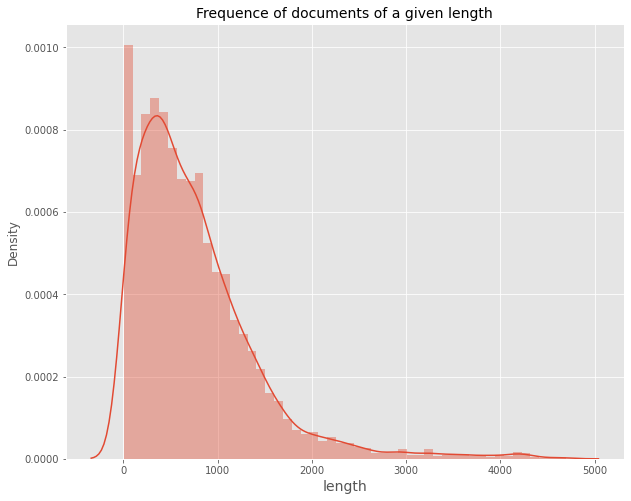

In [8]:

# Plot histogram with the length. Truncate max length to 5000 tokens.
plt.style.use("ggplot")

plt.figure(figsize=(10, 8))
df['length'] = (df['titletext']).apply(lambda x: len(x.split()))
sns.distplot(df[df['length'] < 5000]['length'])
plt.title('Frequence of documents of a given length', fontsize=14)
plt.xlabel('length', fontsize=14)
None

In [9]:
df['titletext'] = df['titletext'].apply(lambda x: " ".join(x.split()[:512]))
df.to_csv(f"/content/prep_news.csv")


## Tokenization & Input Formatting
In this  we'll transform our dataset into the format that BERT can be trained on.

To feed our text to BERT, it must be split into tokens, and then these tokens must be mapped to their index in the tokenizer vocabulary.

The tokenization must be performed by the tokenizer included with BERT--the below cell will download this for us. We'll be using the "uncased" version here.

In [10]:
from transformers import BertTokenizer,AutoModel, AdamW, get_linear_schedule_with_warmup

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


Let's apply the tokenizer to one sentence just to see the output.

In [11]:
# Print the original sentence.
print(' Original: ', df['titletext'][0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(df['titletext'][0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(df['titletext'][0])))

 Original:  You Can Smell Hillary’s Fear. Daniel Greenfield, a Shillman Journalism Fellow at the Freedom Center, is a New York writer focusing on radical Islam. In the final stretch of the election, Hillary Rodham Clinton has gone to war with the FBI. The word “unprecedented” has been thrown around so often this election that it ought to be retired. But it’s still unprecedented for the nominee of a major political party to go war with the FBI. But that’s exactly what Hillary and her people have done. Coma patients just waking up now and watching an hour of CNN from their hospital beds would assume that FBI Director James Comey is Hillary’s opponent in this election. The FBI is under attack by everyone from Obama to CNN. Hillary’s people have circulated a letter attacking Comey. There are currently more media hit pieces lambasting him than targeting Trump. It wouldn’t be too surprising if the Clintons or their allies were to start running attack ads against the FBI. The FBI’s leadership

In [12]:
# Get the lists of text and their labels.
sentences = df.titletext.values
labels = df.label.values

In [13]:
max_len = 0

# For every sentence...
for sent in sentences:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Token indices sequence length is longer than the specified maximum sequence length for this model (619 > 512). Running this sequence through the model will result in indexing errors


Max sentence length:  4262


In [14]:
# Set tokenizer hyperparameters.
MAX_SEQ_LEN = 256
BATCH_SIZE = 16
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)



# Define columns to read.
label_field = Field(sequential=False, use_vocab=False, batch_first=True)
text_field = Field(use_vocab=False, 
                   tokenize=tokenizer.encode, 
                   include_lengths=False, 
                   batch_first=True,
                   fix_length=MAX_SEQ_LEN, 
                   pad_token=PAD_INDEX, 
                   unk_token=UNK_INDEX)


fields = {'titletext' : ('titletext', text_field), 'label' : ('label', label_field)}


# Read preprocessed CSV into TabularDataset and split it into train, test and valid.
train_data, valid_data, test_data = TabularDataset(path='/content/prep_news.csv', 
                                                   format='CSV', 
                                                   fields=fields, 
                                                   skip_header=False).split(split_ratio=[0.70, 0.2, 0.1], 
                                                                            stratified=True, 
                                                                            strata_field='label')
                                                   
# Create train and validation iterators.
train_iter, valid_iter = BucketIterator.splits((train_data, valid_data),
                                               batch_size=BATCH_SIZE,
                                               device=device,
                                               shuffle=True,
                                               sort_key=lambda x: len(x.titletext), 
                                               sort=True, 
                                               sort_within_batch=False)


# Test iterator, no shuffling or sorting required.
test_iter = Iterator(test_data, batch_size=BATCH_SIZE, device=device, train=False, shuffle=False, sort=False)

In [15]:
for i in train_iter:
  print(i.titletext)
  break

tensor([[  101,  1996,  2601,  ...,     0,     0,     0],
        [  101,  2088,  2162,  ...,     0,     0,     0],
        [  101,  3419,  9180,  ...,     0,     0,     0],
        ...,
        [  101,  2067,  2545,  ...,     0,     0,     0],
        [  101, 15333,  2497,  ...,     0,     0,     0],
        [  101,  1996, 27788,  ...,     0,     0,     0]], device='cuda:0')


In [16]:
class BERT_Arch(nn.Module):

    def __init__(self):
      
      super(BERT_Arch, self).__init__()

      #smaller model trained on lower-cased English text (with 12-layer, 768-hidden, 12-heads, 110M parameters)

      self.bert = AutoModel.from_pretrained('bert-base-uncased',return_dict=False) 
      
      # dropout layer
      self.dropout = nn.Dropout(0.1)
      
      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model  
      _, cls_hs = self.bert(sent_id, mask)
      
      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)
      
      # apply softmax activation
      x = self.softmax(x)

      return x

In [17]:
# Functions for saving and loading model parameters and metrics.
def save_checkpoint(path, model, valid_loss):
    torch.save({'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}, path)

    
def load_checkpoint(path, model):    
    state_dict = torch.load(path, map_location=device)
    model.load_state_dict(state_dict['model_state_dict'])
    
    return state_dict['valid_loss']


def save_metrics(path, train_loss_list, valid_loss_list):   
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list }
    
    torch.save(state_dict, path)


def load_metrics(path):    
    state_dict = torch.load(path, map_location=device)
    return state_dict['train_loss_list'], state_dict['valid_loss_list']

In [18]:

def train(model, iterator, optimizer, criterion, clip,scheduler = None):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.titletext
        trg = batch.label
        mask = (src != PAD_INDEX).type(torch.uint8)
        
        optimizer.zero_grad()

        output = model(src, mask)
            
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        scheduler.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [19]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.titletext
            trg = batch.label
            mask = (src != PAD_INDEX).type(torch.uint8)

            output = model(src, mask)
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [20]:
output_path='/content'

In [21]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [22]:
steps_per_epoch = len(train_iter)
CLIP = 1
criterion = nn.CrossEntropyLoss()

model = BERT_Arch()
model = model.to(device)

In [23]:
# # Main training loop
# NUM_EPOCHS = 6

# optimizer = AdamW(model.parameters(), lr=1e-4)
# scheduler = get_linear_schedule_with_warmup(optimizer, 
#                                             num_warmup_steps=steps_per_epoch*1, 
#                                             num_training_steps=steps_per_epoch*NUM_EPOCHS)

# print("======================= Start Pre-training =================================")

# # Pretrain linear layers, do not train bert
# for param in model.bert.parameters():
#   param.requires_grad = False
# for epoch in range(NUM_EPOCHS):

#     start_time = time.time()
    
#     train_loss = train(model, train_iter, optimizer, criterion, CLIP,scheduler=scheduler)
#     valid_loss = evaluate(model, valid_iter, criterion)
    
#     end_time = time.time()
    
#     epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
#     # if valid_loss < best_valid_loss:
#     #     best_valid_loss = valid_loss
#     #     save_checkpoint(output_path + '/model.pkl', model, best_valid_loss)
#     #     save_metrics(output_path + '/metric.pkl', train_loss_list, valid_loss_list)
    
#     print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
#     print(f'\tTrain Loss: {train_loss:.3f}')
#     print(f'\t Val. Loss: {valid_loss:.3f}')


# # Pretrain linear layers, do not train bert
# for param in model.bert.parameters():
#   param.requires_grad = True

# print('Pre-training done!')

In [24]:
# Main training loop

N_EPOCHS = 5

best_valid_loss = float('inf')

print("======================= Start training =================================")
optimizer = AdamW(model.parameters(), lr=2e-6)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=steps_per_epoch*2, 
                                            num_training_steps=steps_per_epoch*N_EPOCHS)

train_loss_list = []
valid_loss_list=[]

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss = train(model, train_iter, optimizer, criterion, CLIP,scheduler=scheduler)
    valid_loss = evaluate(model, valid_iter, criterion)
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        save_checkpoint(output_path + '/model.pkl', model, best_valid_loss)
        save_metrics(output_path + '/metric.pkl', train_loss_list, valid_loss_list)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}  Val. Loss: {valid_loss:.3f}')

print('Training done!')

======================= Start training =================================
Epoch: 01 | Time: 3m 54s
	Train Loss: 0.666  Val. Loss: 0.592
Epoch: 02 | Time: 3m 55s
	Train Loss: 0.423  Val. Loss: 0.260
Epoch: 03 | Time: 3m 55s
	Train Loss: 0.209  Val. Loss: 0.179
Epoch: 04 | Time: 3m 55s
	Train Loss: 0.152  Val. Loss: 0.158
Epoch: 05 | Time: 3m 55s
	Train Loss: 0.137  Val. Loss: 0.145
Training done!


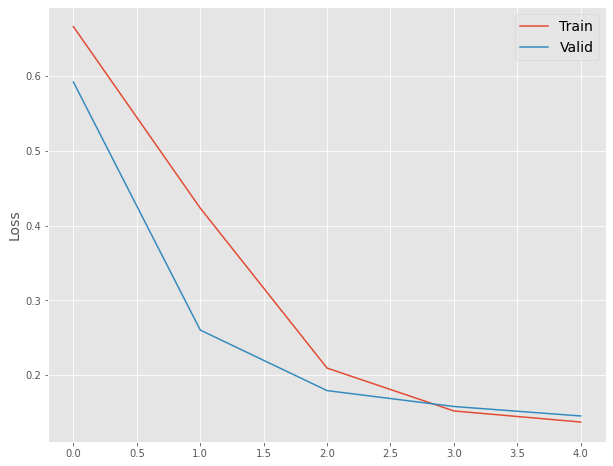

In [27]:
plt.figure(figsize=(10, 8))
train_loss_list, valid_loss_list = load_metrics(output_path + '/metric.pkl')
plt.plot( train_loss_list, label='Train')
plt.plot( valid_loss_list, label='Valid')
# plt.xlabel('Global Steps', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=14)
plt.show()

In [29]:
# Evaluation Function

def evaluate(model, test_loader):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (source, target), _ in test_loader:
                mask = (source != PAD_INDEX).type(torch.uint8)
                
                output = model(source, mask)

                y_pred.extend(torch.argmax(output, axis=-1).tolist())
                y_true.extend(target.tolist())
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax = plt.subplot()

    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['FAKE', 'REAL'])
    ax.yaxis.set_ticklabels(['FAKE', 'REAL'])

Classification Report:
              precision    recall  f1-score   support

           1     0.9165    0.9700    0.9425       634
           0     0.9677    0.9105    0.9383       626

    accuracy                         0.9405      1260
   macro avg     0.9421    0.9403    0.9404      1260
weighted avg     0.9420    0.9405    0.9404      1260



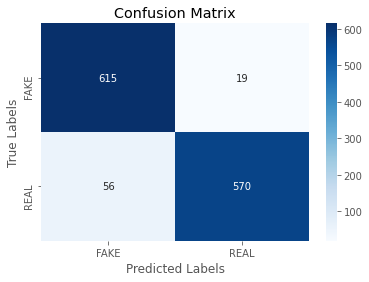

In [30]:
# model = BERT_Arch()
# model = model.to(device)

load_checkpoint(output_path + '/model.pkl', model)

evaluate(model, test_iter)